In [18]:
import numpy as np
import random
from keras.datasets import mnist
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2 
from google.colab.patches import cv2_imshow

In [3]:
def ReLU(vector):
  return np.array([max(0,vector[i]) for i in range(len(vector))])

def softmax(vector):
  e_i = np.exp(vector)
  return e_i/e_i.sum()

In [4]:
class OurNeuralNetwork:
  '''
  The structure of NN:
    - input layer with 784 neurons (x1, ... , x784)
    - activation function: ReLU
    - hidden layer with 128 neurons (h1, ... , h128)
    - activation function:: softmax
    - output layer with 11 neurons (o1, ... , o11)

    - loss function: Cross Entropy Loss
    - updating weights and biases: Nesterov Accelerated Gradient Descent Method
  '''
  def __init__(self):

    # initializing weights and biases
    self.W1 = np.array([[random.uniform(-0.0001, 0.0001) for i in range(784)] for j in range(128)])
    self.b1 = np.zeros(128) #np.array([random.uniform(-0.001, 0.001) for j in range(128)])
    self.W2 = np.array([[random.uniform(-0.0001, 0.0001) for i in range(128)] for j in range(11)])
    self.b2 = np.zeros(11) #np.array([random.uniform(-0.001, 0.001) for j in range(11)])

    self.learning_rate = 0.0001  # learning rate
    self.momentum = 0.9  # gamma constant for NAG
    self.epochs = 100  # number of epochs
    self.batch_size = 40

  def training(self, X, Y, X_val, Y_val):
   
    # possible modes: training/validation

    # Identity matrix
    E = np.eye(11)

    CE = {'training': [], 'validation': []}  # cross entropy loss by epochs

    for epoch in tqdm(range(self.epochs)):

      for mode in ['training', 'validation']:

        CE_total = 0  # cross entropy loss for 1 epoch
      
        if mode=='training':
          # v_t-1 - velocity on the previous step 
          prev_v_b1 = np.zeros(128) 
          prev_v_W1 = np.zeros((128,784))
          prev_v_b2 = np.zeros(11)
          prev_v_W2 = np.zeros((11,128))
          n = len(X)
        else:
          n = len(X_val)

        for i in range((n - 1) // self.batch_size + 1):
          if mode=='training':
            # creating a batch of data in training mode
            start_i = i * self.batch_size
            end_i = start_i + self.batch_size
            Xb = X[start_i:end_i]
            Yb = Y[start_i:end_i]

            # v_t - velocity on the next step 
            v_b1 = self.momentum*prev_v_b1
            v_W1 = self.momentum*prev_v_W1
            v_b2 = self.momentum*prev_v_b2
            v_W2 = self.momentum*prev_v_W2

            # saving current parameters of our NN
            prev_W1 = self.W1
            prev_b1 = self.b1
            prev_W2 = self.W2
            prev_b2 = self.b2

            # counting new parameters of NN
            self.W1 -= v_W1
            self.b1 -= v_b1
            self.W2 -= v_W2
            self.b2 -= v_b2

            # initializing gradients
            dCE_db1 = np.zeros(128) 
            dCE_db2 = np.zeros(11)
            dCE_dW1 = np.zeros((128,784))
            dCE_dW2 = np.zeros((11,128))
          else:
            # creating a batch of data in validation mode
            start_i = i * self.batch_size
            end_i = start_i + self.batch_size
            Xb = X_val[start_i:end_i]
            Yb = Y_val[start_i:end_i]

          for x,y in zip(Xb,Yb):
            # feed_forward
            h_ = self.W1.dot(x)+self.b1
            h = ReLU(h_)
            z = self.W2.dot(h)+self.b2
            output = softmax(z)

            CE_total += np.log(output[y])

            if mode=='training':
              # counting gradients
              dCE_db2 += output-E[y]
              dCE_dW2 += ((output-E[y]).reshape((11,1))).dot(h.reshape((128,1)).T)
              dCE_db1 += (self.W2-self.W2[y]).T.dot(output)*(h>0) #.reshape((11,1))
              dCE_dW1 += (((self.W2-self.W2[y]).T.dot(output)*(h>0)).reshape((128,1))).dot(x.reshape((784,1)).T)

          if mode=='training':
            self.W1 = prev_W1
            self.W2 = prev_W2
            self.b1 = prev_b1
            self.b2 = prev_b2

            v_W1 += self.learning_rate*dCE_dW1
            v_W2 += self.learning_rate*dCE_dW2
            v_b1 += self.learning_rate*dCE_db1
            v_b2 += self.learning_rate*dCE_db2

            # updating gradients
            self.W1 -= v_W1
            self.W2 -= v_W2
            self.b1 -= v_b1
            self.b2 -= v_b2

            prev_v_b1 = v_b1
            prev_v_b2 = v_b2
            prev_v_W1 = v_W1
            prev_v_W2 = v_W2

        CE_total *=(-1.)
        CE[mode].append(CE_total)

        if mode=='training':
          print(f'epoch № {epoch}, CE_loss = {CE_total}')
          print(f"output = {output}")
        
        if mode=='training' and epoch%10==0:
          print(f"W1 = {self.W1}")
          print(f"b1 = {self.b1}")
          print(f"W2 = {self.W2}")
          print(f"b2 = {self.b2}")

    return CE

  def predict(self,x,y):
    output = softmax(self.W2.dot(ReLU(self.W1.dot(x)+self.b1))+self.b2)
    answ = np.argmax(output)
    return 'None' if answ==10 else answ


11501568/11490434 [==============================] - 0s 0us/step


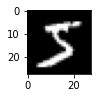

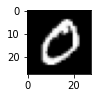

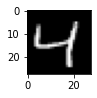

In [5]:
# loading training and validation datasets
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# visualization of 3 first images
for i in range(3):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [6]:
# data scaling and converting to another shape
train_X_scal_resh = train_X.reshape((train_X.shape[0], 784))
train_X_scal_resh = (train_X_scal_resh-128.)/256.
test_X_scal_resh = test_X.reshape((test_X.shape[0], 784))
test_X_scal_resh = (test_X_scal_resh-128.)/256.

In [7]:
network = OurNeuralNetwork()

In [8]:
# network.learning_rate = 0.0001
# network.momentum = 0.85
# network.batch_size = 50
network.epochs = 100

In [9]:
%%time
CE_loss = network.training(train_X_scal_resh, train_y, test_X_scal_resh, test_y)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch № 0, CE_loss = 50180.36267298975
output = [1.30826936e-02 6.11860131e-05 9.08628118e-03 3.12453183e-03
 1.81927169e-04 4.46665167e-02 1.31728314e-04 1.76344982e-03
 8.17449013e-01 1.10394525e-01 5.81473607e-05]
W1 = [[ 2.19324422e-05  1.20995746e-06 -1.40603731e-05 ... -8.26442930e-05
   2.43846859e-05 -6.73957960e-05]
 [ 3.17069858e-06 -1.18832757e-05  6.26872182e-05 ... -3.02243854e-05
  -3.12063891e-05 -4.67497821e-05]
 [-1.10716361e-02 -1.10287864e-02 -1.10633494e-02 ... -1.11021027e-02
  -1.10991937e-02 -1.10668948e-02]
 ...
 [-9.47607727e-05 -9.67696677e-05  4.75549012e-05 ...  1.66385765e-05
  -7.37638294e-05  2.03349735e-05]
 [-6.18917713e-03 -6.25646898e-03 -6.20557148e-03 ... -6.24790931e-03
  -6.30559526e-03 -6.15202886e-03]
 [-5.67109615e-03 -5.77229835e-03 -5.79862952e-03 ... -5.72787760e-03
  -5.78375175e-03 -5.77899409e-03]]
b1 = [-6.18410977e-06 -1.59368404e-06  2.22548740e-02  1.07652669e-02
  1.51918800e-02 -2.30623529e-08  6.03760926e-03  6.79106679e-03
  6.077

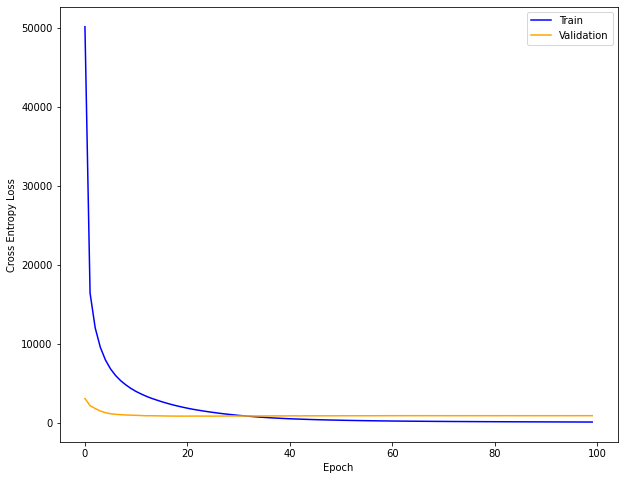

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(CE_loss['training'], label="Train", color="blue")
plt.plot(CE_loss['validation'], label="Validation", color="orange")
# plt.plot(history_lr_val[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
# plt.ylim([0, 75])
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch");

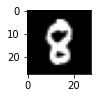

true digit: 8
predicted digit: 8



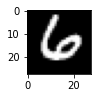

true digit: 6
predicted digit: 6



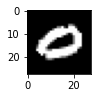

true digit: 0
predicted digit: 0



In [17]:
# some predictions

for i in range(3):
  ind = random.randint(0, train_X.shape[0])
  pyplot.subplot(330 + 1+i)
  pyplot.imshow(train_X[ind], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

  train_X_pred = train_X[ind].reshape(784)
  train_X_pred = (train_X_pred-128.)/256.
  prediction = network.predict(train_X_pred, train_y[ind])
  print(f"true digit: {train_y[ind]}")
  print(f"predicted digit: {prediction}")
  print()

In [27]:
np.savez_compressed('W1', network.W1)
np.savez_compressed('W2', network.W2)
np.savez_compressed('b1', network.b1)
np.savez_compressed('b2', network.b2)